In [1]:
!pip install medmnist

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1129)'))) - skipping


In [2]:
from medmnist import ChestMNIST
dataset = ChestMNIST(split='train', download=True, transform=None)

100%|██████████| 82.8M/82.8M [01:35<00:00, 869kB/s] 


In [3]:
dataset_test = ChestMNIST(split='test', download=True, transform=None)

Using downloaded and verified file: C:\Users\Administrator\.medmnist\chestmnist.npz


In [4]:
disease_names = [
    "肺不张", "肺气肿", "胸腔积液", "气胸", "肺炎",
    "肺结核", "肺结节", "纤维化", "水肿", "气胸",
    "肿块", "支气管炎", " cardiomegaly（心脏肥大）", "正常"
]
dataset

Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: C:\Users\Administrator\.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0

In [5]:
len(dataset), len(dataset_test)

(78468, 22433)

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Text(0.5, 1.0, '[0 0 0 0 0 0 0 0 0 0 0 0 0 0]')

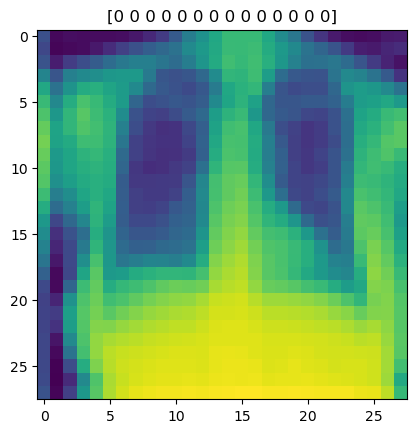

In [7]:
img, label = dataset[0]
plt.imshow(img)
plt.title(label)

In [8]:
Transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset_t = [(Transform(img), label) for img, label in dataset]
dataset_test_t = [(Transform(img), label) for img, label in dataset_test]

Text(0.5, 1.0, '[0 0 0 0 0 0 0 0 0 0 0 0 0 0]')

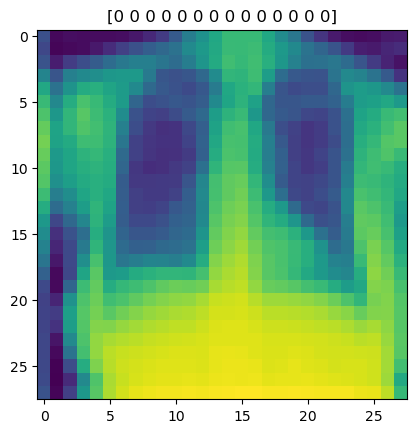

In [9]:
img_t, label = dataset_t[0]
img_t = img_t.squeeze(0).numpy()
plt.imshow(img_t)
plt.title(label)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # 提取低级特征(纹理， 边缘)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # 提取高级特征
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
    self.relu2 = nn.ReLU()

    # 映射高纬
    self.fc1 = nn.Linear(32*7*7, 64)
    self.relu3 = nn.ReLU()

    # 输出概率预测
    self.fc2 = nn.Linear(64, 14)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
        x1 = self.conv1(x) 
        x_relu1 = self.relu1(x1)
        # 修正：变量名统一为 x_pool1（后续要使用，避免拼写错误）
        x_pool1 = self.pool(x_relu1)

        # 现在用 x_pool1（和上面定义的变量名一致）
        x2 = self.conv2(x_pool1)
        x_relu2 = self.relu2(x2)
        x_pool2 = self.pool(x_relu2)

        x_flat = x_pool2.view(-1, 32 * 7 * 7)
        x3 = self.fc1(x_flat)
        x_relu3 = self.relu3(x3)

        x4 = self.fc2(x_relu3)
        x_sigmoid = self.sigmoid(x4)

        return {
            "input": x,              # 输入数据（处理后的Tensor）
            "conv1": x1,             # 卷积1未激活
            "relu1": x_relu1,        # ReLU1激活映射
            "relu2": x_relu2,        # ReLU2激活映射
            "relu3": x_relu3,        # ReLU3激活映射
            "sigmoid": x_sigmoid     # Sigmoid激活映射（输出）
        }

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
print("模型初始化完成：", model)
print(f'设备名称:{torch.cuda.get_device_name(0)}')

batch_size = 32  # 每批32个样本（可调整，显存小就设16）
train_loader = DataLoader(
    dataset_t,
    batch_size=batch_size,
    shuffle=True,  # 训练集打乱，增加随机性
    num_workers=2
)
test_loader = DataLoader(
    dataset_test_t,
    batch_size= batch_size,
    shuffle=False,
    num_workers=2
)


# 提取激活映射（修正 model.eval() 位置，规范写法）
batch_imgs, batch_labels = next(iter(train_loader))
batch_imgs = batch_imgs.to(device)

model.eval()  # 先设为评估模式，再禁用梯度计算（规范顺序）
with torch.no_grad():
    activations = model(batch_imgs)

模型初始化完成： SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=14, bias=True)
  (sigmoid): Sigmoid()
)
设备名称:NVIDIA GeForce RTX 3060


In [11]:
criterion = nn.BCELoss()
optimizer = optim.Adam(
    model.parameters(),  # 优化模型所有可训练参数
    lr=1e-3,             # 学习率（太大可能震荡，太小训练太慢）
    weight_decay=1e-5    # 可选：L2正则化，防止过拟合
)
num_epochs = 10  # 训练轮数（1轮=遍历所有训练样本1次）
best_val_loss = float('inf')  # 记录最好的验证损失（用于保存最优模型）

In [12]:
train_losses = []
val_losses = []
epochs = 10

for epoch in range(epochs):
  model.train()
  running_train_loss = 0.0

  for batch_idx, (batch_imgs, batch_labels) in enumerate(train_loader):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device).float()

    # 梯度清零
    optimizer.zero_grad()

    # 训练
    output = model(batch_imgs)
    pred = output['sigmoid']

    # 计算损失
    loss = criterion(pred, batch_labels)

    # 反向传播，计算梯度
    loss.backward()

    # 参数更新
    optimizer.step()

    # 累计损失
    running_train_loss += loss.item()

  epoch_train_loss = running_train_loss / len(train_loader)
  train_losses.append(epoch_train_loss)

  # 开始验证
  model.eval()  # 切换到评估模式（禁用Dropout、固定BatchNorm等）
  running_val_loss = 0.0

  with torch.no_grad():  # 禁用梯度计算，加快速度、节省内存
      for batch_imgs, batch_labels in test_loader:
          batch_imgs = batch_imgs.to(device)
          batch_labels = batch_labels.to(device).float()

          # 前向传播（只预测，不计算梯度）
          outputs = model(batch_imgs)
          pred = outputs['sigmoid']

          # 计算验证损失
          val_loss = criterion(pred, batch_labels)
          running_val_loss += val_loss.item()

  # 计算当前轮的平均验证损失
  epoch_val_loss = running_val_loss / len(test_loader)
  val_losses.append(epoch_val_loss)
  print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

  # 保存最优模型
  if epoch_val_loss < best_val_loss:
    best_val_loss = epoch_val_loss
    torch.save({
        'epoch':epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }, 'best_model.pth')
    print(f"→ 保存最优模型（Val Loss: {best_val_loss:.4f}）")
print("="*50)
print("训练完成！最优模型已保存为 best_chestmnist_model.pth")

Epoch [1/10], Train Loss: 0.1783, Val Loss: 0.1892
→ 保存最优模型（Val Loss: 0.1892）
Epoch [2/10], Train Loss: 0.1718, Val Loss: 0.1733
→ 保存最优模型（Val Loss: 0.1733）
Epoch [3/10], Train Loss: 0.1692, Val Loss: 0.1722
→ 保存最优模型（Val Loss: 0.1722）
Epoch [4/10], Train Loss: 0.1674, Val Loss: 0.1705
→ 保存最优模型（Val Loss: 0.1705）
Epoch [5/10], Train Loss: 0.1659, Val Loss: 0.1705
Epoch [6/10], Train Loss: 0.1647, Val Loss: 0.1697
→ 保存最优模型（Val Loss: 0.1697）
Epoch [7/10], Train Loss: 0.1635, Val Loss: 0.1695
→ 保存最优模型（Val Loss: 0.1695）
Epoch [8/10], Train Loss: 0.1626, Val Loss: 0.1696
Epoch [9/10], Train Loss: 0.1616, Val Loss: 0.1682
→ 保存最优模型（Val Loss: 0.1682）
Epoch [10/10], Train Loss: 0.1608, Val Loss: 0.1690
训练完成！最优模型已保存为 best_chestmnist_model.pth


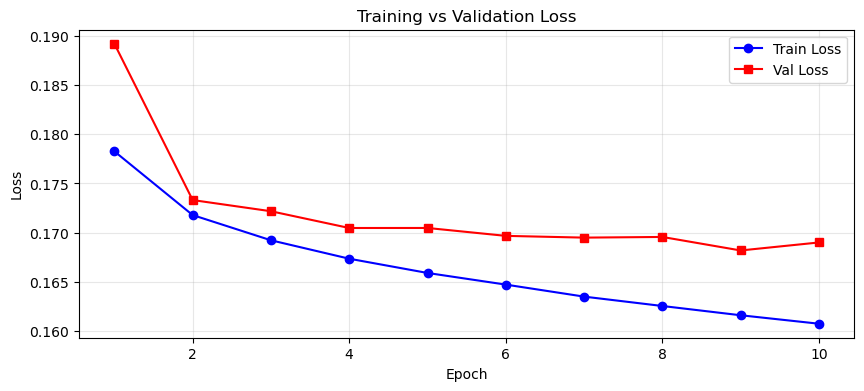

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', color='red', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(pred_labels, true_labels):
    # 展平为一维数组（sklearn指标要求）
    pred_flat = pred_labels.cpu().numpy().flatten()
    true_flat = true_labels.cpu().numpy().flatten()

    precision = precision_score(true_flat, pred_flat, average='macro')
    recall = recall_score(true_flat, pred_flat, average='macro')
    f1 = f1_score(true_flat, pred_flat, average='macro')
    return precision, recall, f1

# 测试时计算指标
with torch.no_grad():
    all_pred = []
    all_true = []
    for batch_imgs, batch_labels in test_loader:
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device).float()
        outputs = model(batch_imgs)
        pred = outputs['sigmoid']
        all_pred.append((pred > 0.5).float())
        all_true.append(batch_labels)

    all_pred = torch.cat(all_pred)
    all_true = torch.cat(all_true)
    precision, recall, f1 = calculate_metrics(all_pred, all_true)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.7729, Recall: 0.5074, F1-score: 0.5016
